In [3]:
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import PyWGCNA

In [4]:
scpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/scrnaseq/scVI_Atherosclerosis_Atlas_V2.h5ad'
sc_dat = sc.read_h5ad(scpath)
sc.pp.filter_cells(sc_dat, min_genes=200)
sc.pp.filter_genes(sc_dat, min_cells=3)
sc_dat = sc_dat.raw.to_adata()
#sc_dat.obs['Disease'].unique()
# get disease data
disease_scdat = sc_dat[sc_dat.obs['Disease'] != 'Healthy',]
# normalize
#disease_scdat = disease_scdat.raw.to_adata()
disease_scdat.var_names_make_unique() 
sc.pp.normalize_total(disease_scdat, target_sum=1e4)



In [6]:
sc_datori = sc.read_h5ad(scpath)

In [8]:
sc_datori.obs['Main_Cell_Types'].value_counts()

VSMC                     30476
T cells                  28340
Macrophage               23696
Fibroblast               23031
Endothelial              10740
Pericytes                 4925
Endothelial (DKK2+)       2927
B cells                   2725
Mast cells                1499
Osteoblastic cells        1301
Plasma cells              1284
Neuronal cells             719
Lymphatic Endothelial      304
cDC1                       177
pDC                        155
Neutrophils                124
Name: Main_Cell_Types, dtype: int64

In [9]:
sc_datori

AnnData object with n_obs × n_vars = 132423 × 8000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [5]:
sc_dat

AnnData object with n_obs × n_vars = 123476 × 33539
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering', 'n_genes'
    var: 'features'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [13]:
disease_scdat

AnnData object with n_obs × n_vars = 63889 × 33539
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering', 'n_genes'
    var: 'features'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [24]:
n_cells = disease_scdat.shape[0]
n_genes = disease_scdat.shape[1]
n_cells_keep = int(np.ceil(n_cells * 0.005))
n_genes_keep = int(np.ceil(n_genes * 0.005))
# Randomly subset the scanpy object
disease_scdat_sampled = disease_scdat[np.random.choice(disease_scdat.shape[0], size=n_cells_keep), np.random.choice(disease_scdat.shape[1], size=n_genes_keep)]


In [25]:
disease_scdat_sampled

View of AnnData object with n_obs × n_vars = 320 × 168
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering', 'n_genes'
    var: 'features'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [36]:
def coexp_list(data, goi):
    res_array = data.multiply(data[goi], axis=0)
    coexp_count = np.count_nonzero(res_array, axis=0)
    coexp_frac = coexp_count/len(data)
    return coexp_frac


In [58]:
coexp_list(exp_dat, 'ID3').shape

(500,)

In [60]:
matrix2 = np.empty((0, len(exp_dat.columns)))
for gene in exp_dat.columns[:10]:
    temp_array = coexp_list(exp_dat, gene)
    # Append the new row to the empty array
    matrix2 = np.append(matrix2, [temp_array], axis=0)

In [61]:
matrix2.shape

(10, 500)

In [44]:
exp_dat = pd.DataFrame(disease_scdat.X.toarray(), columns=disease_scdat.var_names)
exp_dat = exp_dat.iloc[:, :500]
exp_dat[exp_dat < threshold] = 0

In [45]:
with mp.Pool(num_processes) as pool:
    temp_arrays = pool.starmap(coexp_list, [(exp_dat, gene) for gene in exp_dat.columns])

# Task 2: Append the new rows to the empty matrix
matrix = np.vstack(temp_arrays)

In [46]:
matrix.shape


(500, 500)

In [49]:
(matrix == 0).sum().sum()

160747

In [48]:
500 * 500

250000

In [71]:
num_processes = mp.cpu_count()

In [75]:
matrix.shape

(500, 500)

In [54]:
import multiprocessing as mp

In [65]:
def coexp_sub(exp_dat,genelist,result_queue):
    matrix = np.empty((0, len(exp_dat.columns)))
    for gene in exp_dat.columns:
        temp_array = coexp_list(exp_dat, gene)
        # Append the new row to the empty array
        matrix = np.append(matrix, [temp_array], axis=0)
    result_queue.put(matrix)

In [70]:
my_list = exp_dat.columns.to_list()
result_queue = mp.Queue()
n = int(len(my_list)//2)
# Split the list into 4 sub-lists
sub_list1 = my_list[:n]
sub_list2 = my_list[n:]

p1 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list1, result_queue))
p2 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list2, result_queue))

# Start the processes
p1.start()
p2.start()

# Wait for the processes to finish
p1.join()
p2.join()




KeyboardInterrupt: 

In [ ]:
# Retrieve the results from the queue
results = np.empty((0, len(exp_dat.columns)))
while not result_queue.empty():
    results = np.stack([results, result_queue.get()], axis=0)

In [66]:
def subprocess_literature(exp_dat,my_list):
    result_queue = mp.Queue()
    n = int(len(my_list)//4)
    # Split the list into 4 sub-lists
    sub_list1 = my_list[:n]
    sub_list2 = my_list[n:2*n]
    sub_list3 = my_list[2*n:3*n]
    sub_list4 = my_list[3*n:]

    p1 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list1, result_queue))
    p2 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list2, result_queue))
    p3 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list3, result_queue))
    p4 = mp.Process(target=coexp_sub, args=(exp_dat,sub_list4, result_queue))

    # Start the processes
    p1.start()
    p2.start()
    p3.start()
    p4.start()
    # Wait for the processes to finish
    p1.join()
    p2.join()
    p3.join()
    p4.join()
    
    # Retrieve the results from the queue
    results = np.empty((0, len(exp_dat.columns)))
    while not result_queue.empty():
        results = np.stack([results, result_queue.get()], axis=0)
    
    return results

In [67]:
matrix2 = subprocess_literature(exp_dat,exp_dat.columns.tolist())

KeyboardInterrupt: 

In [ ]:
def coexp_list(data, goi):
    res_array = data.multiply(data[goi], axis=0)
    coexp_count = np.count_nonzero(res_array, axis=0)
    coexp_frac = coexp_count/len(data)
    return coexp_frac
def coexp_matrix(adata, threshold):
    exp_dat = pd.DataFrame(adata.X.toarray(),columns=adata.var_names)
    exp_dat[exp_dat < threshold] = 0
    # Create an empty array with a specified shape (e.g., 0 rows, len(exp_dat.columns)) columns)
    matrix = np.empty((0, len(exp_dat.columns)))
    for gene in exp_dat.columns:
        temp_array = coexp_list(exp_dat, gene)
        # Append the new row to the empty array
        matrix = np.append(matrix, [temp_array], axis=0)
    return matrix , exp_dat.columns

In [ ]:
ori_sc_all_cell_coxp_matrix = coexp_matrix(disease_scdat_sampled,threshold)

In [8]:
arr1 = np.where(disease_scdat.X.toarray() < 1, 0, disease_scdat.X.toarray())

In [12]:
np.count_nonzero(arr1),np.count_nonzero(arr3),np.count_nonzero(arr5),

(93206253, 43265248, 23643671)

In [10]:
arr3 = np.where(disease_scdat.X.toarray() < 3, 0, disease_scdat.X.toarray())

In [11]:
arr5 = np.where(disease_scdat.X.toarray() < 5, 0, disease_scdat.X.toarray())

In [6]:
exp_dat = pd.DataFrame(disease_scdat.X.toarray(),columns=disease_scdat.var_names)

KeyboardInterrupt: 

In [3]:
disease_scdat

AnnData object with n_obs × n_vars = 70025 × 33539
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering'
    var: 'features'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [4]:
len(disease_scdat.var_names)

33539

In [13]:
local_stringdb = os.path.join('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/string/lfs-stringdb/')
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()

stringnames = set(list(name2stringId.keys()))

disease_scdat = disease_scdat[:, disease_scdat.var_names.isin(list(stringnames))]
exp_dat2 = pd.DataFrame(disease_scdat.X.toarray(),columns=disease_scdat.var_names)

In [14]:
exp_dat2.max().max()

3756.6846

In [5]:
stpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/ST/ST_plaque_all.h5ad'
st_dat = sc.read_h5ad(stpath)
#st_dat.obs['Disease'].unique()
# get disease data
disease_stdat = st_dat[st_dat.obs['condition'] == 'Plaque',]
# normalize
#disease_stdat = disease_stdat.raw.to_adata()
disease_stdat.var_names_make_unique() 
sc.pp.normalize_total(disease_stdat, target_sum=1e4)

In [6]:
len(disease_stdat.var_names)

17943

In [4]:


local_stringdb = os.path.join('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/string/lfs-stringdb/')
df = pd.read_csv(local_stringdb+'9606.protein.info.v12.0.txt', sep='\t', header=0, usecols=['#string_protein_id', 'preferred_name'])
df['preferred_name'] = df['preferred_name'].str.upper()
stringId2name = df.set_index('#string_protein_id')['preferred_name'].to_dict()
name2stringId = df.set_index('preferred_name')['#string_protein_id'].to_dict()

stringnames = set(list(name2stringId.keys()))

disease_stdat = disease_stdat[:, disease_stdat.var_names.isin(list(stringnames))]


threshold = 0.477

In [7]:
exp_dat = pd.DataFrame(disease_stdat.X.toarray(),columns=disease_stdat.var_names)
#exp_dat[exp_dat < threshold] = 0

In [10]:
exp_dat.max().max()

2291.8276

In [11]:
exp_dat.min().min()

0.0

In [1]:
import pickle

# Open the pickle file for reading
with open('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/co_exp/sc_all_cell_coxp_matrix.pkl', 'rb') as f:
    # Load the data from the file
    data = pickle.load(f)

In [10]:
np.count_nonzero(data[0])

64000000

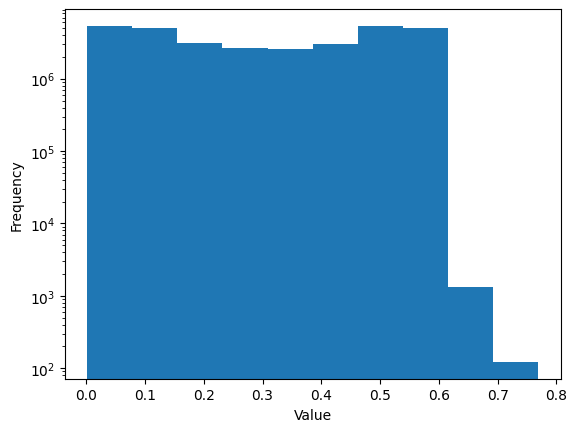

In [17]:


# Create a histogram of the non-zero values
hist, bins = np.histogram(data[0].flatten(), bins=10)

# Plot the histogram
plt.hist(nonzero_vals, bins=bins)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

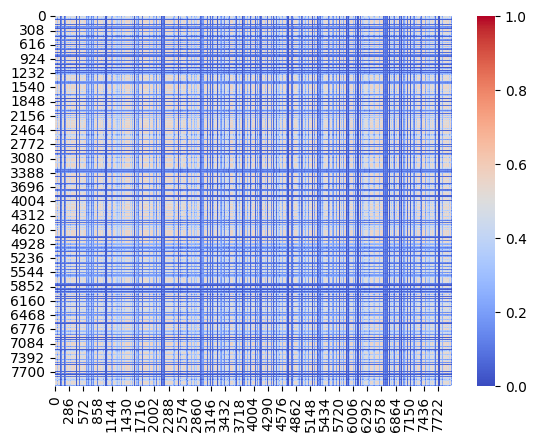

In [13]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt



# Create a heatmap of the matrix
sns.heatmap(data[0], cmap='coolwarm', vmin=0, vmax=1)

# Show the plot
plt.show()


In [58]:
## scdata
scpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/scrnaseq/scVI_Atherosclerosis_Atlas_V2.h5ad'
sc_dat = sc.read_h5ad(scpath)


In [60]:
sc_dat1 = sc_dat.raw.to_adata()

In [62]:
sc_dat

AnnData object with n_obs × n_vars = 132423 × 8000
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering'
    var: 'features', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches', 'mean', 'std'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

In [61]:
sc_dat1

AnnData object with n_obs × n_vars = 132423 × 33539
    obs: 'nCount_RNA', 'nFeature_RNA', 'Tissue', 'Disease', 'Donor', 'Study', 'State', 'Artery', 'Assay', 'percent.mt', 'Doublets', 'Sex', '_scvi_batch', '_scvi_labels', 'leiden01', 'leiden02', 'Main_Cell_Types', 'Subclustering'
    var: 'features'
    uns: 'Main_Cell_Types_colors', 'Study_colors', 'Subclustering_colors', '_scvi_manager_uuid', '_scvi_uuid', 'hvg', 'leiden', 'leiden01_colors', 'leiden02_colors', 'log1p', 'neighbors', 'pca', 'umap'
    obsm: 'X_pca', 'X_scVI', 'X_umap'
    obsp: 'connectivities', 'distances'

In [65]:
print(sc_dat.X.shape, sc_dat.var_names.shape)
print(sc_dat1.X.shape, sc_dat1.var_names.shape)

(132423, 8000) (8000,)
(132423, 33539) (33539,)


In [66]:
print(type(sc_dat),type(sc_dat.var_names))
print(type(sc_dat1),type(sc_dat1.var_names))

<class 'anndata._core.anndata.AnnData'> <class 'pandas.core.indexes.base.Index'>
<class 'anndata._core.anndata.AnnData'> <class 'pandas.core.indexes.base.Index'>


In [59]:
pd.DataFrame(sc_dat.X,columns=sc_dat.var_names)

,AL645608.1,SAMD11,AL645608.8,HES4,ISG15,AL645608.2,AGRN,TNFRSF18,TNFRSF4,B3GALT6,...,MT-CO2,MT-ATP6,MT-CO3,MT-ND3,MT-ND6,MT-CYB,AC141272.1,AC004556.1,AC233755.2,AC233755.1
0,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,0.336328,0.231733,0.473018,0.076976,-0.449742,0.663424,-0.004255,-0.08544,-0.017663,-0.018759
1,-0.061247,-0.148576,-0.074127,3.871669,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,4.320353,...,0.070836,0.396075,0.409549,-0.800283,-0.449742,0.798984,-0.004255,-0.08544,-0.017663,-0.018759
2,-0.061247,-0.148576,-0.074127,-0.433018,1.823479,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,1.417253,1.282303,1.570191,0.829886,-0.449742,1.195358,-0.004255,-0.08544,-0.017663,-0.018759
3,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,0.186007,-1.170924,-0.234110,-0.256139,-0.449742,0.658561,-0.004255,-0.08544,-0.017663,-0.018759
4,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,-0.453892,0.793072,1.323606,1.220384,-0.449742,0.530527,-0.004255,-0.08544,-0.017663,-0.018759
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132418,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,-1.146420,-1.050703,-0.360821,-1.325247,-0.449742,-1.896158,-0.004255,-0.08544,-0.017663,-0.018759
132419,-0.061247,-0.148576,-0.074127,-0.433018,1.267499,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,-1.338775,-0.599876,-0.871581,-1.389377,-0.449742,-0.787846,-0.004255,-0.08544,-0.017663,-0.018759
132420,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,-0.137061,-0.429341,-0.075470,-0.521197,-0.449742,-0.574660,-0.004255,-0.08544,-0.017663,-0.018759
132421,-0.061247,-0.148576,-0.074127,-0.433018,-0.503891,-0.01357,-0.184675,-0.162817,-0.180556,-0.232237,...,-0.840451,-3.498116,0.003658,-1.086703,-0.449742,-0.212175,-0.004255,-0.08544,-0.017663,-0.018759


In [68]:
pd.DataFrame(sc_dat1.X.toarray(),columns=sc_dat1.var_names)

,MIR1302-2HG,FAM138A,OR4F5,AL627309.1,AL627309.3,AL627309.2,AL627309.4,AL732372.1,OR4F29,AC114498.1,...,BX072566.1,AL354822.1,AC023491.2,AC004556.1,AC233755.2,AC233755.1,AC240274.1,AC213203.1,FAM231C,RMRP.1
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
132418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
132419,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
132421,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [25]:
#sc_dat.obs['Disease'].unique()
# get disease data
disease_scdat = sc_dat[sc_dat.obs['Disease'] != 'Healthy']
# disease_scdat = sc_dat[sc_dat.obs['Disease'] != 'Healthy']
# normalize
#disease_scdat = disease_scdat.raw.to_adata()
disease_scdat.var_names_make_unique() 
sc.pp.normalize_total(disease_scdat, target_sum=1e4)

In [1]:
disease_scdat.var_names

NameError: name 'disease_scdat' is not defined

In [48]:
disease_scdat.X.shape

(10840, 17943)

In [2]:
st_all_cell_coxp_matrix = 999
import pickle
with open('/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/gzn/thesis/co_exp/st_all_cell_coxp_matrix.pkl', 'wb') as f:
    pickle.dump(st_all_cell_coxp_matrix, f)

In [44]:
sc_dat.shape

(132423, 33539)

In [45]:
disease_scdat.shape

(10840, 17943)

In [47]:
np.count_nonzero(disease_scdat.X.data > 1)/(10840* 17943)



0.06779475719853337

In [28]:
disease_scdat.obs['Disease'].unique()


['Proximal plaques', 'type VII calcified plaques', 'atherosclerotic plaques', 'atherosclerotic lesions']
Categories (4, object): ['Proximal plaques', 'atherosclerotic lesions', 'atherosclerotic plaques', 'type VII calcified plaques']

In [33]:
## stdata
stpath = '/novo/omdb/pds02/PDS2843/data/sprint_tid_ascvd/data/ST/ST_plaque_all.h5ad'
st_dat = sc.read_h5ad(stpath)
#st_dat.obs['Disease'].unique()
# get disease data
disease_scdat = st_dat[st_dat.obs['condition'] == 'Plaque',]
# normalize
#disease_scdat = disease_scdat.raw.to_adata()
disease_scdat.var_names_make_unique() 
sc.pp.normalize_total(disease_scdat, target_sum=1e4)

In [40]:
st_dat

AnnData object with n_obs × n_vars = 16593 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'n_counts', 'sample', '_indices', 'B cells', 'Endothelial', 'Fibroblast', 'Macrophage', 'Mast cells', 'Neuron', 'Pericyte', 'Plasma cells', 'T cells', 'VSMC', 'cell_type', 'condition'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'MT', 'X_spatial_FW104302', 'X_spatial_FW104306', 'X_spatial_FW104860', 'X_spatial_FW106005_v2', 'X_spatial_FW106006', 'X_spatial_FW106008', 'X_spatial_FW106010', 'X_spatial_FW106012', 'X_spatial_FW106014', 'X_spatial_FW106016', 'X_spatial_FW106018', 'X_spatial_FW106022', 'X_spatial_Merged', 'means_cell_abundance_w_sf', 'q05_cell_abundance_w_sf', 'q95_cell_abundance_w_sf', 'stds_cell_abundance_w_sf'

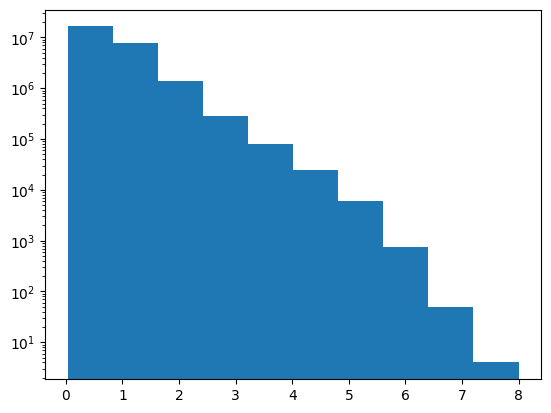

In [41]:
# Flatten the matrix values
flat_data = st_dat.X.data.flatten()

# Create a histogram plot with a log scale on the y-axis
plt.hist(flat_data, bins=10)
plt.yscale('log')

# Show the plot
plt.show()

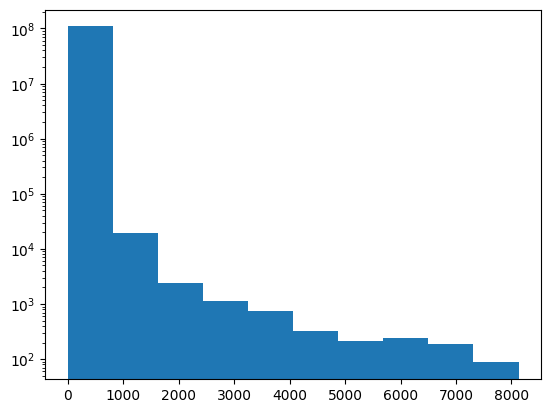

In [30]:
# Flatten the matrix values
flat_data = disease_scdat.X.data.flatten()

# Create a histogram plot with a log scale on the y-axis
plt.hist(flat_data, bins=10)
plt.yscale('log')

# Show the plot
plt.show()

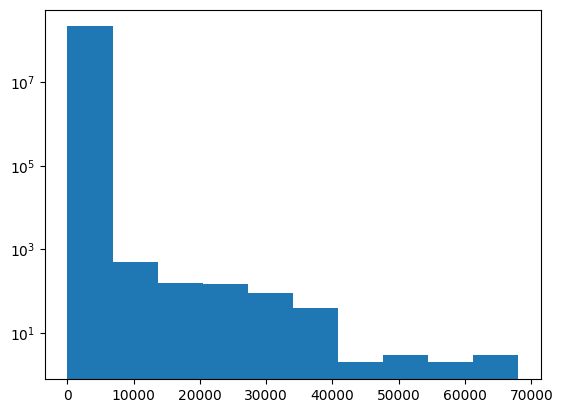

In [20]:
# Flatten the matrix values
flat_data = a.X.data.flatten()

# Create a histogram plot with a log scale on the y-axis
plt.hist(flat_data, bins=10)
plt.yscale('log')

# Show the plot
plt.show()

In [7]:
disease_scdat.X

array([[  1.0969179 ,   2.6609344 ,   1.3275927 , ...,   1.5301955 ,
          0.31634602,   0.33597282],
       [  4.120972  ,   9.996771  ,   4.9875865 , ...,   5.748738  ,
          1.1884692 ,   1.2622044 ],
       [  1.3284901 ,   3.2226892 ,   1.6078632 , ...,   1.853238  ,
          0.3831304 ,   0.40690064],
       ...,
       [ -0.4357417 ,  -1.0570346 ,  -0.5273754 , ...,  -0.60785776,
         -0.12566589,  -0.13346247],
       [ -5.2535467 , -12.744203  ,  -6.358334  , ...,  -7.3286743 ,
         -1.5150985 ,  -1.6090986 ],
       [ -1.2302183 ,  -2.9842985 ,  -1.4889253 , ...,  -1.7161491 ,
         -0.35478923,  -0.37680113]], dtype=float32)

In [3]:
threshold = 1

In [4]:
# create co-exp matrix
def coexp_list(data, goi):
        res_array = data.multiply(data[goi], axis=0)
        coexp_count = np.count_nonzero(res_array, axis=0)
        coexp_frac = coexp_count/len(data)
        return coexp_frac
def coexp_matrix(adata, threshold):
    exp_dat = pd.DataFrame(adata.X.toarray(),columns=adata.var_names)
    exp_dat[exp_dat < threshold] = 0
    # Create an empty array with a specified shape (e.g., 0 rows, len(exp_dat.columns)) columns)
    matrix = np.empty((0, len(exp_dat.columns)))
    for gene in exp_dat.columns:
        temp_array = coexp_list(exp_dat, gene)
        # Append the new row to the empty array
        matrix = np.append(matrix, [temp_array], axis=0)
    return matrix

In [ ]:
threshold = 1
sc_all_cell_coxp_matrix = coexp_matrix(disease_scdat,threshold)
st_all_cell_coxp_matrix = coexp_matrix(disease_scdat,threshold)
## if you want to create matrix per cell type, modify the adata input for coexp_matrix
# storage = []
# celltypes = disease_scdat.obs['Main_Cell_Types'].tolist()
# for celltype in celltypes:
#     cell_adata = disease_scdat[disease_scdat.obs['Main_Cell_Types'] == celltype]
#     storage.append(coexp_matrix(cell_adata,threshold))